In [1]:
# %matplotlib widget

import sys
sys.path.append("./../scripts")
import PandemiXFunctions as pf
import PandemiXModelFunctions as pmf

import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12,8)
plt.rcParams['figure.facecolor'] = (1,1,1,1)
plt.rcParams["image.cmap"] = "tab10"
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab10.colors)
fs_label = 16
parameters = {
                'axes.labelsize': fs_label,
                'axes.titlesize': fs_label+4,
                'xtick.labelsize': fs_label,
                'ytick.labelsize': fs_label, 
                'legend.fontsize': fs_label, 
                'lines.markersize': 10,
                'lines.linewidth': 3
             }
plt.rcParams.update(parameters)

import datetime
             
from scipy.integrate import cumtrapz
# int_I = cumtrapz(np.exp(u_H*ts)*Is,ts, initial=0)
# Hs = np.exp(-u_H*ts) * (r_chr*pars_full['gamma']*int_I + k) 

In [2]:
saveFigures = True
# saveFigures = False

In [3]:
# Reload PandemiXModelFunctions, in case changes have been made
import importlib 
importlib.reload(pmf)

<module 'PandemiXModelFunctions' from 'c:\\Users\\rakrpe\\GithubRepos\\PandemiX\\modelling\\PandemiXModelFunctions.py'>

In [4]:
modelMetaWaning = ({
     'beta * S * I' : ['S','I'],
     'nu * I' : ['I','R'],
     'rho * R': ['R','S'],
},
['S','I','R'],['beta','nu','rho'])

modelMetaWaning_add = ({
     'beta * S * I' : ['S','I'],
     'nu * I' : ['I','R'],
     'rho * R': ['R','S'],
     'rho * S / 10': [None,'I'],
},
['S','I','R'],['beta','nu','rho'])



In [5]:
# Initialize everything

DKpop = 5800000
curPop = 10000
iniInf = 10

I_0 = iniInf/curPop 
R_0 = 0
S_0 = 1 - I_0 - R_0 

init = {'S' : S_0,'I':I_0,'R':I_0}

R0 = 2
nu = 1/5
beta = R0*nu 
alpha = 1/(80 * 365.25)
rho = 1/(365.25)
rho = 1/(2*365.25)
pars = {'beta':beta,'nu':nu,'rho':rho}

tEnd = np.round(10*365.25)
sch1 = pmf.Scheme(modelMetaWaning,init,pars,0,tEnd,Changes=[])
# sch1 = pmf.Scheme(modelMetaWaning_add,init,pars,0,tEnd,Changes=[])

# Add a blank change after one year, to force high time resolution initially
curChange = pmf.Change(365)
sch1.addChange(curChange)

sch1.simulate(tRes=1000)
res1 = sch1.result
ts = res1.t 
ty = ts/365.25

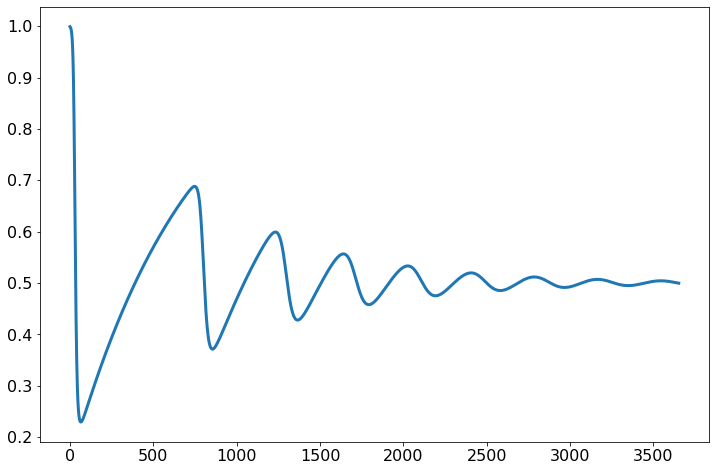

In [6]:
fig,ax = plt.subplots()
ax.plot(ts,res1.S)

In [7]:

## Arbitrary function definitions
def ArbitraryGillespieCall(t,x,ps,modelFlows,varsMeta,parsMeta):

    # Calculate sum of population
    N = np.sum(x)

    # Go through variable names and get inputs
    for i in range(len(varsMeta)):
        vName = varsMeta[i]
        exec(vName+' = x['+str(i)+']')
        # exec(vName+' = xNorm['+str(i)+']')
        
    # Go through parameter names and save
    for i in range(len(parsMeta)):
        pName = parsMeta[i]
        exec(pName+' = ps['+str(i)+']')

    # Calculate the value of each current flow
    allFlows = np.zeros(len(modelFlows))
    i = 0
    for key in modelFlows:
        allFlows[i] = eval(key)
        i = i + 1

    flowTot = allFlows.sum()
    
    if (flowTot == None):
        return 0,x 

    # print(f'flowTot: {flowTot}, x:{x}')

    r1 = np.random.rand()
    r2 = np.random.rand()
    
    timeStep = np.log(1/r1) / flowTot 

    # print(allFlows)
    # print(allFlows/flowTot)
    # print(np.cumsum(allFlows/flowTot))
    # curBounds = np.append(0,np.cumsum(allFlows/flowTot))
    curBounds = np.cumsum(allFlows/flowTot)
    # print(curBounds)

    xOut = x.copy()
    curReaction = None
    i = 0
    while (i < len(curBounds)):
        if (r2 < curBounds[i]):
            curReaction = i 
            i = len(curBounds)
        i += 1
    
    if (curReaction == None):
        return 0,x 

    reactionFlow = list(modelFlows)[curReaction]
    # print(reactionFlow)
    curToChange = modelFlows[reactionFlow]
    # print(curToChange)
    if (curToChange[0] != None):
        curOut = np.where(curToChange[0] == np.array(varsMeta))[0][0]
        xOut[curOut] -= 1
    if (curToChange[1] != None):
        curIn = np.where(curToChange[1] == np.array(varsMeta))[0][0]
        xOut[curIn] += 1

    return timeStep,xOut


# # ArbitraryGillespieCall(0,[0.99,0.01],(2/7,1/7),*testMeta)
# # curInit =100* np.array([0.99,0.01])
# testInit = [20000,1000]
# ArbitraryGillespieCall(0,testInit,(2/7,1/7),*testMeta)



In [8]:
def multiGillespie(tInit,tEnd,xInit,pars,ModelMeta):
    
    allTs = [tInit]
    allXs = xInit 

    curInit = xInit 
    curT = tInit 
    while (curT < tEnd):
            
        dt,curInit = ArbitraryGillespieCall(curT,curInit,pars,*ModelMeta)
        curT += dt

        allTs.append(curT) 
        allXs = np.vstack([allXs,curInit])
        
        if (dt == 0):
            curT = tEnd
    return allTs,np.array(allXs)

# ts,xs = multiGillespie(0,10,[99,10],(1/70,1/7),testMeta)

In [9]:
# testInit 
init 
# testInit = [DKpop-10,10,0]
curPop = 10000
testInit = [curPop-10,10,0]
# testPars = [0.4,0.2,1/(2*365.25)]
testPars = [0.4/curPop,0.2,1/(2*365.25)]
# testPars = [0.4/curPop,0.2,2/(365.25)]

ArbitraryGillespieCall(0,testInit,testPars,*modelMetaWaning) 


(0.19585217468097213, [9990, 9, 1])

In [10]:

ts_gil,xs = multiGillespie(0,600,testInit,testPars,modelMetaWaning)

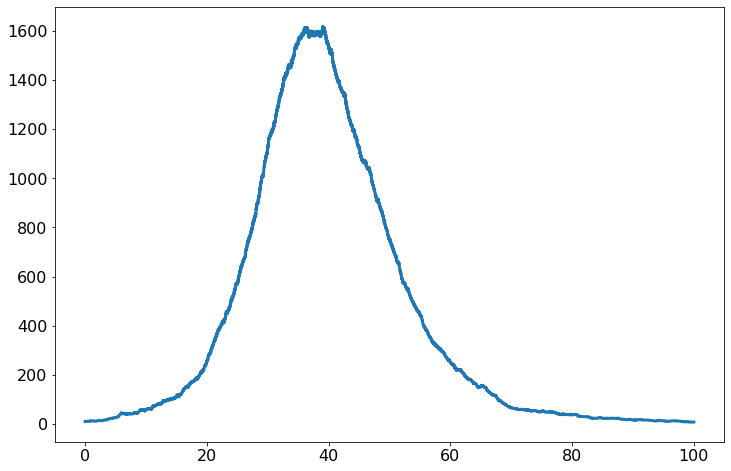

In [11]:
fig,ax = plt.subplots() 
# ax.plot(ts_gil,xs,'k') 
# ax.plot(ts_gil,xs[:,1],'k') 
ax.plot(ts_gil,xs[:,1]) 

In [12]:

testInit2 = xs[-1,:]
testInit2[0] -= 1
testInit2[1] += 1
testInit2 
ts_gil_2,xs_2 = multiGillespie(600,2000,testInit2,testPars,modelMetaWaning)

In [13]:
fig,ax = plt.subplots() 
ax.plot(ts_gil,xs,'k') 
# ax.plot(ts_gil_2,xs_2)  

for k in range(10):
    
    ts_gil_2,xs_2 = multiGillespie(600,2000,testInit2,testPars,modelMetaWaning)
    ax.plot(ts_gil_2,xs_2,'k:',alpha=0.5)  

ax.plot(ts,curPop*res1.S)
ax.plot(ts,curPop*res1.I)
ax.plot(ts,curPop*res1.R)


ax.set_xlim(left=0,right=1000)

In [ ]:
# ax.set_ylim([0,1000])

C:\Users\rakrpe\AppData\Local\Temp\ipykernel_1776\58909028.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


(0.0, 500.0)

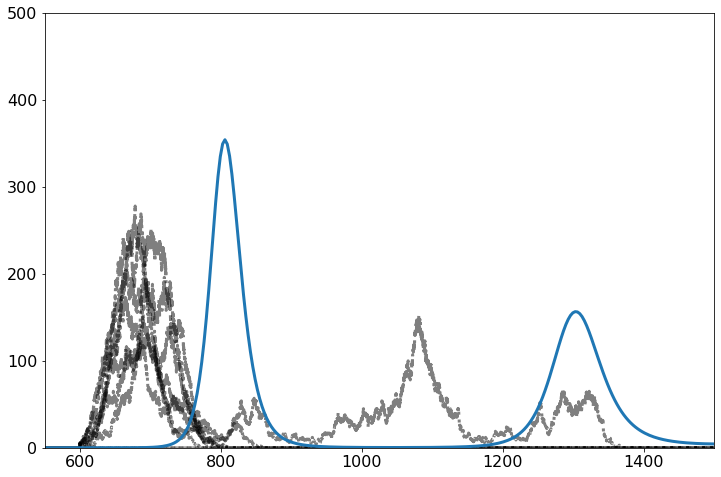

In [ ]:
fig,ax = plt.subplots() 
ax.plot(ts_gil,xs[:,1],'k') 
# ax.plot(ts_gil_2,xs_2)  

for k in range(10):
    
    ts_gil_2,xs_2 = multiGillespie(600,2000,testInit2,testPars,modelMetaWaning)
    ax.plot(ts_gil_2,xs_2[:,1],'k:',alpha=0.5)  

# ax.plot(ts,curPop*res1.S)
ax.plot(ts,curPop*res1.I)
# ax.plot(ts,curPop*res1.R)


ax.set_xlim(left=550,right=1500)
ax.set_ylim([0,500])

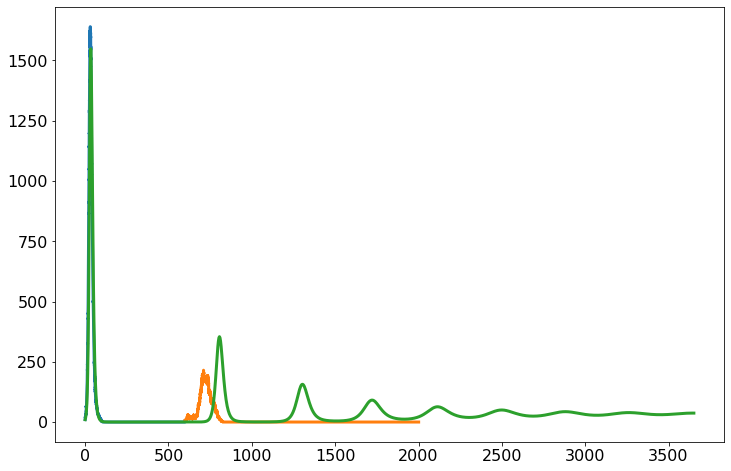

In [ ]:
fig,ax = plt.subplots() 
ax.plot(ts_gil,xs[:,1]) 
ax.plot(ts_gil_2,xs_2[:,1]) 
ax.plot(ts,curPop*res1.I)


# ax.set_xlim(left=0,right=100)
# ax.set_ylim([0,10])
# ax.set_yscale('log')